In [67]:
%%capture
%pip install transformers datasets

---
---

# Word2Vec Model

---
---

### **NOTE:** Both the Word2Vec model implementation and the classification task will be fused in this singular notebook to simplify the loading process of the checkpoints.

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn
import math
from torch.utils.data import DataLoader
from tabulate import tabulate
from datasets import load_dataset
from torch.utils.data import Dataset

from tqdm.notebook import tqdm
from transformers import BertTokenizer


# Move the model to the appropriate device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data loading


Let's start by loading the dataset and printing it to see what it looks like.

In [69]:
dataset = load_dataset("scikit-learn/imdb", split="train")
print(dataset)

Dataset({
    features: ['review', 'sentiment'],
    num_rows: 50000
})


# Pre-processing / Tokenization

This is a very important step. It maybe boring but very important. In this session we will be lazy, but in real life, the time spent on inspecting and cleaning data is never wasted. It is true for text, but also for everything.



In PyTorch, everything is tensor. Words are replaced by indices. A sentence, is therefore a sequence of indices (long integers). In the first HW, you constructed a `WhiteSpaceTokenizer`. Here we will use an already built tokenizer. It is more appropriate to transformers. It relies on sub-word units, and converts everything in lower case. This is not always the best choice, but here it will be sufficient. To quote the documentation, this tokenizer allows you to:
- Tokenize (splitting strings in sub-word token strings), convert tokens strings to ids and back, and encoding/decoding (i.e., tokenizing and converting to integers).
- Add new tokens to the vocabulary in a way that is independent of the underlying structure (BPE, SentencePiece…).
- Manage special tokens (like mask, beginning-of-sentence, etc.): adding them, assigning them to attributes in the tokenizer for easy access and making sure they are not split during tokenization.

Here we are going to use the tokenizer from the well known Bert model, that we can directly download.

In [70]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

In [71]:
def preprocessing_fn(x, tokenizer):
    x["review_ids"] = tokenizer(
        x["review"],
        add_special_tokens=False,
        truncation=True,
        max_length=256,
        padding=False,
        return_attention_mask=False,
    )["input_ids"]
    x["label"] = 0 if x["sentiment"] == "negative" else 1
    return x

After reading the documentation about HuggingFace dataset, we can now do the following:
- Shuffle the dataset
- For computational reasons, use only a total of **5000 samples**.
- Tokenize the dataset with the `preprocessing_fn`. (*Hint: use the `Dataset.map` method from HuggingFace*).
- Keep only columns `review_ids` and `label`.
- Make a train/validation split, (**80% / 20%**). Call these dataset `train_set` and `valid_set`.


In [72]:
n_samples = 2500  # the number of training example
seed = 42 # random seed for our model so we can reproduce our results

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# We first shuffle the data !
shuffled_dataset = dataset.shuffle(seed=seed)

# Select 5000 samples
small_dataset = shuffled_dataset.select(range(n_samples))

# Tokenize the dataset
tok_dataset = small_dataset.map(preprocessing_fn,
                                fn_kwargs={'tokenizer': tokenizer})

# Remove useless columns
tok_dataset = tok_dataset.select_columns(['review_ids', 'label'])

# Split the train and validation
tok_dataset = tok_dataset.train_test_split(test_size=0.2, seed=seed)

document_train_set = tok_dataset['train']
document_valid_set = tok_dataset['test']

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

In [73]:
print(document_train_set)

Dataset({
    features: ['review_ids', 'label'],
    num_rows: 2000
})


# Implementation

This section will include the steps and workflow followed for the creation of my own Word2Vec model. Each question corresponding to the instructions.pdf will be clearly labeled and explained below.

## Data preprocessing

1. Can be found in the sections above, I applied the same preprocessing to get a dataset (with the same tokenizer)
with a `train` and a `validation` split, with two columns `review_ids` (list of int) and `label` (int).

2. Below, is the function `extract_words_contexts`. To handle the borders and ensure that every context has the same size, I am using a padding token that allows words at the beginning and end of our data to still be extracted along with their contexts. This is represented by `padding_token` in my function below. By padding at both ends, I ensure that even the first and last words of the document can have a full context window. I have chosen a padding token ID of `0` because it does not clash with any word IDs in my dataset, and has a set label of ['PAD'] when printing the words and contexts.

In [74]:
def extract_words_contexts(ids, R, padding_token=0):
    words = []
    contexts = []

    padded_ids = [padding_token] * R + ids + [padding_token] * R

    for i in range(R, len(padded_ids) - R):
        word = padded_ids[i]
        context = padded_ids[i-R:i] + padded_ids[i+1:i+R+1]

        words.append(word)
        contexts.append(context)

    return words, contexts

3. Below is the function `flatten_dataset_to_list` that applies the function
`extract_words_contexts` on the whole dataset.

In [75]:
def flatten_dataset_to_list(dataset, R):
    all_words = []
    all_contexts = []

    for document in dataset:
        words, contexts = extract_words_contexts(document['review_ids'], R)

        all_words.extend(words)
        all_contexts.extend(contexts)

    return all_words, all_contexts

4. I will now apply the function to my initial `document_train_set` and `document_valid_set` to get the corresponding flattened lists. I will also print some example outputs to get a look at what the `extract_words_contexts` function is doing.


In [76]:
R = 6
K = 10

flat_train_words, flat_train_contexts = flatten_dataset_to_list(document_train_set, R)
flat_valid_words, flat_valid_contexts = flatten_dataset_to_list(document_valid_set, R)


print("Example outputs:")
for i in range(5):  # Adjust the range to see more or fewer examples
    print(f"Central Word ID: {flat_train_words[i]}")
    print(f"Context IDs: {flat_train_contexts[i]}")
    print("-" * 20)

Example outputs:
Central Word ID: 3819
Context IDs: [0, 0, 0, 0, 0, 0, 3313, 3021, 2005, 1996, 27762, 9781]
--------------------
Central Word ID: 3313
Context IDs: [0, 0, 0, 0, 0, 3819, 3021, 2005, 1996, 27762, 9781, 2100]
--------------------
Central Word ID: 3021
Context IDs: [0, 0, 0, 0, 3819, 3313, 2005, 1996, 27762, 9781, 2100, 1000]
--------------------
Central Word ID: 2005
Context IDs: [0, 0, 0, 3819, 3313, 3021, 1996, 27762, 9781, 2100, 1000, 12218]
--------------------
Central Word ID: 1996
Context IDs: [0, 0, 3819, 3313, 3021, 2005, 27762, 9781, 2100, 1000, 12218, 2940]
--------------------


5. I will now embed these lists in two valid PyTorch `Dataset`, and call them `train_set` and `valid_set`.

In [77]:
class TextDataset(Dataset):
    def __init__(self, words, contexts):
        self.words = words
        self.contexts = contexts

    def __len__(self):
        return len(self.words)

    def __getitem__(self, idx):
        return {
            'word_id': self.words[idx],
            'context_ids': self.contexts[idx]
        }

train_set = TextDataset(flat_train_words, flat_train_contexts)
valid_set = TextDataset(flat_valid_words, flat_valid_contexts)


6. I will now make the `collate_fn` function that adds the negative context to the batch. It will be parameterized by the scaling factor K, and the output of `collate_fn` will be the Python dictionary that can be seen in the code below. It contains the necessary information on word IDs, positive context IDs, and negative context IDs. For the negative context, I will randomly sample from the whole vocabulary set. This is done with the `random` package to sample from `tokenizer.vocab_size`. Since we are using the `BERT` tokenizer which already has its own vocabulary set, we can randomly sample directly from that vocabulary.

In [78]:
import random
random.seed(seed)

def collate_fn(batch, R, K):
    word_ids = [item['word_id'] for item in batch]
    positive_context_ids = [item['context_ids'] for item in batch]
    negative_context_ids = [random.sample(range(tokenizer.vocab_size), 2*K*R) for _ in batch]

    return {
        'word_id': torch.tensor(word_ids),
        'positive_context_ids': torch.tensor(positive_context_ids),
        'negative_context_ids': torch.tensor(negative_context_ids)
    }

7. Now I will wrap everything in a `DataLoader` to simplify access to training and validation data that will be used to actually train the final model. I chose a batch size (defined by `B`) of 32 to start, as recommended by the authors of the BERT model.

In [79]:
B = 64 # Batch size

train_dataloader = DataLoader(
    train_set, batch_size=B, collate_fn=lambda x: collate_fn(x, R, K)
)
valid_dataloader = DataLoader(
    valid_set, batch_size=B, collate_fn=lambda x: collate_fn(x, R, K)
)
n_valid = len(valid_set)
n_train = len(train_set)

8. I will now make 2 or 3 three iterations in the `DataLoader` and print R, K and the
shapes of all the tensors in the batches.

In [80]:
for _ in range(3):
    for batch in train_dataloader:
        print(f"R: {R}, K: {K}")
        print("word_id shape:", batch['word_id'].shape)
        print("positive_context_ids shape:", batch['positive_context_ids'].shape)
        print("negative_context_ids shape:", batch['negative_context_ids'].shape)
        break  # To only print the first batch

R: 6, K: 10
word_id shape: torch.Size([64])
positive_context_ids shape: torch.Size([64, 12])
negative_context_ids shape: torch.Size([64, 120])
R: 6, K: 10
word_id shape: torch.Size([64])
positive_context_ids shape: torch.Size([64, 12])
negative_context_ids shape: torch.Size([64, 120])
R: 6, K: 10
word_id shape: torch.Size([64])
positive_context_ids shape: torch.Size([64, 12])
negative_context_ids shape: torch.Size([64, 120])


## Model

I will now build my `Word2Vec` model, and implement it. It will be defined as a class that inherits from the `torch.nn.Module`. The model will be parametrized by the vocabulary size, which we discussed earlier, and the embeddings dimension. I am using the module `torch.nn.Embedding`. I will start with a recommended amount of 100 embeddings. This can be changed later on to help tune the model and increase accuracy.

In [81]:
class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(Word2Vec, self).__init__()
        # Embedding table for target words
        self.target_embeddings = nn.Embedding(vocab_size, embedding_dim)
        # Embedding table for context words
        self.context_embeddings = nn.Embedding(vocab_size, embedding_dim)

    def forward(self, target_words, context_words, labels):
        # Get embeddings for target words
        target_embeds = self.target_embeddings(target_words)
        # Get embeddings for context words
        context_embeds = self.context_embeddings(context_words)
        # Compute the dot product
        scores = torch.bmm(context_embeds, target_embeds.unsqueeze(2)).squeeze(2)
        # Apply sigmoid function to get probabilities
        probs = torch.sigmoid(scores)

        return probs


vocab_size = len(tokenizer.vocab)  # BERT tokenizer vocabulary size
d = 100 # number of embedding dimensions

model_word2vec = Word2Vec(vocab_size, d)

I will define some hyperparameters, as well as define the optimizer. I am using the popular `Adam` optimizer. I will then initiate the device so that I can train my model on a GPU if possible to accelerate the process.

I have chosen the below hyperparameters based on the recommendations of the authors of the BERT paper once again. This can also be changed later on to help tune the model and increase accuracy.

In [82]:
# Hyperparameters
learning_rate = 5e-5
epsilon = 1e-08
E = 30  # Number of epochs

# Define the optimizer
optimizer = torch.optim.AdamW(model_word2vec.parameters(), lr=learning_rate, eps=epsilon)
optimizer_1 = torch.optim.Adam(model_word2vec.parameters(), lr=learning_rate)

model_word2vec.to(device)

Word2Vec(
  (target_embeddings): Embedding(30522, 100)
  (context_embeddings): Embedding(30522, 100)
)

I can now train my model using the below `train_word2vec` function, and validate the accuracy on the test set using the `validate_word2vec` function. The training will be parametrized by the batch size B, and the number of epochs E, define previously.

In [83]:
def train_model(model, train_loader, valid_loader, E, optimizer, device):
    list_val_acc = []
    list_train_acc = []
    list_train_loss = []
    list_val_loss = []
    criterion = nn.BCELoss()

    for e in range(E):
        model.train()
        total_loss = 0
        correct_predictions = 0
        total_predictions = 0

        for batch in tqdm(train_loader):
            # Get data from the batch
            word_ids = batch['word_id'].to(device)
            pos_context_ids = batch['positive_context_ids'].to(device)
            neg_context_ids = batch['negative_context_ids'].to(device)

            # Combine positive and negative context ids
            context_ids = torch.cat((pos_context_ids, neg_context_ids), dim=1)

            # Labels: 1 for positive context, 0 for negative context
            labels = torch.cat((torch.ones(pos_context_ids.size(0), pos_context_ids.size(1)),
                                torch.zeros(neg_context_ids.size(0), neg_context_ids.size(1))), dim=1).to(device)

            # Forward pass
            optimizer.zero_grad()
            preds = model(word_ids, context_ids, labels)
            loss = criterion(preds, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Calculate the binary predictions
            with torch.no_grad():
                predictions = (preds > 0.5).float()
                correct_predictions += (predictions == labels).sum().item()
                total_predictions += labels.numel()

            total_loss += loss.item()

        # Calculate average loss and accuracy
        avg_loss = total_loss / len(train_loader)
        accuracy = 100 * (correct_predictions / total_predictions)

        list_train_loss.append(avg_loss)
        list_train_acc.append(accuracy)

        # Validate the model after each epoch
        val_loss, val_acc = validate_model(model, valid_dataloader, device)
        list_val_loss.append(val_loss)
        list_val_acc.append(val_acc)

        print(
            f"Epoch {e+1}\n\t - Train loss: {list_train_loss[-1]:.4f}",
            f"Train acc: {list_train_acc[-1]:.4f}",
            f"Val loss: {list_val_loss[-1]:.4f}",
            f"Val acc: {list_val_acc[-1]:.4f}"
        )
    return list_train_loss, list_train_acc, list_val_loss, list_val_acc


def validate_model(model, valid_loader, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    criterion = nn.BCELoss()

    with torch.no_grad():
        for batch in tqdm(valid_loader):
            word_ids = batch['word_id'].to(device)
            pos_context_ids = batch['positive_context_ids'].to(device)
            neg_context_ids = batch['negative_context_ids'].to(device)
            context_ids = torch.cat((pos_context_ids, neg_context_ids), dim=1)
            labels = torch.cat((torch.ones(pos_context_ids.size(0), pos_context_ids.size(1)),
                                torch.zeros(neg_context_ids.size(0), neg_context_ids.size(1))), dim=1).to(device)

            preds = model(word_ids, context_ids, labels)
            loss = criterion(preds, labels)

            # Calculate the binary predictions
            predictions = (preds > 0.5).float()
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.numel()

            total_loss += loss.item()

        # Calculate average loss and accuracy
        avg_loss = total_loss / len(valid_loader)
        accuracy = 100 * (correct_predictions / total_predictions)
        return avg_loss, accuracy


Let's train the model ! The output of my functions containing the accuracy and loss for each epoch can be seen below after running the code.

In [84]:
list_train_loss, list_train_acc, list_val_loss, list_val_acc = train_model(
    model_word2vec, train_dataloader, valid_dataloader, E, optimizer, device)

  0%|          | 0/6418 [00:00<?, ?it/s]

  0%|          | 0/1620 [00:00<?, ?it/s]

Epoch 1
	 - Train loss: 6.8258 Train acc: 50.3089 Val loss: 6.2543 Val acc: 50.6940


  0%|          | 0/6418 [00:00<?, ?it/s]

  0%|          | 0/1620 [00:00<?, ?it/s]

Epoch 2
	 - Train loss: 5.7456 Train acc: 51.1361 Val loss: 5.2869 Val acc: 51.5889


  0%|          | 0/6418 [00:00<?, ?it/s]

  0%|          | 0/1620 [00:00<?, ?it/s]

Epoch 3
	 - Train loss: 4.8709 Train acc: 52.1298 Val loss: 4.5205 Val acc: 52.7794


  0%|          | 0/6418 [00:00<?, ?it/s]

  0%|          | 0/1620 [00:00<?, ?it/s]

Epoch 4
	 - Train loss: 4.1905 Train acc: 53.5909 Val loss: 3.9119 Val acc: 54.5228


  0%|          | 0/6418 [00:00<?, ?it/s]

  0%|          | 0/1620 [00:00<?, ?it/s]

Epoch 5
	 - Train loss: 3.6376 Train acc: 55.7683 Val loss: 3.4119 Val acc: 57.1451


  0%|          | 0/6418 [00:00<?, ?it/s]

  0%|          | 0/1620 [00:00<?, ?it/s]

Epoch 6
	 - Train loss: 3.1770 Train acc: 58.8869 Val loss: 2.9804 Val acc: 60.7329


  0%|          | 0/6418 [00:00<?, ?it/s]

  0%|          | 0/1620 [00:00<?, ?it/s]

Epoch 7
	 - Train loss: 2.7766 Train acc: 62.8719 Val loss: 2.6093 Val acc: 64.9993


  0%|          | 0/6418 [00:00<?, ?it/s]

  0%|          | 0/1620 [00:00<?, ?it/s]

Epoch 8
	 - Train loss: 2.4306 Train acc: 67.1695 Val loss: 2.2894 Val acc: 69.2034


  0%|          | 0/6418 [00:00<?, ?it/s]

  0%|          | 0/1620 [00:00<?, ?it/s]

Epoch 9
	 - Train loss: 2.1342 Train acc: 71.1318 Val loss: 2.0215 Val acc: 72.7978


  0%|          | 0/6418 [00:00<?, ?it/s]

  0%|          | 0/1620 [00:00<?, ?it/s]

Epoch 10
	 - Train loss: 1.8901 Train acc: 74.3082 Val loss: 1.8026 Val acc: 75.5264


  0%|          | 0/6418 [00:00<?, ?it/s]

  0%|          | 0/1620 [00:00<?, ?it/s]

Epoch 11
	 - Train loss: 1.6907 Train acc: 76.6519 Val loss: 1.6262 Val acc: 77.5080


  0%|          | 0/6418 [00:00<?, ?it/s]

  0%|          | 0/1620 [00:00<?, ?it/s]

Epoch 12
	 - Train loss: 1.5243 Train acc: 78.4455 Val loss: 1.4726 Val acc: 79.1165


  0%|          | 0/6418 [00:00<?, ?it/s]

  0%|          | 0/1620 [00:00<?, ?it/s]

Epoch 13
	 - Train loss: 1.3836 Train acc: 79.9189 Val loss: 1.3421 Val acc: 80.4680


  0%|          | 0/6418 [00:00<?, ?it/s]

  0%|          | 0/1620 [00:00<?, ?it/s]

Epoch 14
	 - Train loss: 1.2619 Train acc: 81.1813 Val loss: 1.2292 Val acc: 81.6323


  0%|          | 0/6418 [00:00<?, ?it/s]

  0%|          | 0/1620 [00:00<?, ?it/s]

Epoch 15
	 - Train loss: 1.1557 Train acc: 82.2846 Val loss: 1.1340 Val acc: 82.6600


  0%|          | 0/6418 [00:00<?, ?it/s]

  0%|          | 0/1620 [00:00<?, ?it/s]

Epoch 16
	 - Train loss: 1.0593 Train acc: 83.2881 Val loss: 1.0424 Val acc: 83.5780


  0%|          | 0/6418 [00:00<?, ?it/s]

  0%|          | 0/1620 [00:00<?, ?it/s]

Epoch 17
	 - Train loss: 0.9780 Train acc: 84.1702 Val loss: 0.9638 Val acc: 84.4376


  0%|          | 0/6418 [00:00<?, ?it/s]

  0%|          | 0/1620 [00:00<?, ?it/s]

Epoch 18
	 - Train loss: 0.9029 Train acc: 84.9875 Val loss: 0.8969 Val acc: 85.1971


  0%|          | 0/6418 [00:00<?, ?it/s]

  0%|          | 0/1620 [00:00<?, ?it/s]

Epoch 19
	 - Train loss: 0.8365 Train acc: 85.7305 Val loss: 0.8361 Val acc: 85.8883


  0%|          | 0/6418 [00:00<?, ?it/s]

  0%|          | 0/1620 [00:00<?, ?it/s]

Epoch 20
	 - Train loss: 0.7761 Train acc: 86.4071 Val loss: 0.7787 Val acc: 86.5293


  0%|          | 0/6418 [00:00<?, ?it/s]

  0%|          | 0/1620 [00:00<?, ?it/s]

Epoch 21
	 - Train loss: 0.7238 Train acc: 87.0229 Val loss: 0.7300 Val acc: 87.1056


  0%|          | 0/6418 [00:00<?, ?it/s]

  0%|          | 0/1620 [00:00<?, ?it/s]

Epoch 22
	 - Train loss: 0.6757 Train acc: 87.5946 Val loss: 0.6864 Val acc: 87.6353


  0%|          | 0/6418 [00:00<?, ?it/s]

  0%|          | 0/1620 [00:00<?, ?it/s]

Epoch 23
	 - Train loss: 0.6328 Train acc: 88.1171 Val loss: 0.6425 Val acc: 88.1469


  0%|          | 0/6418 [00:00<?, ?it/s]

  0%|          | 0/1620 [00:00<?, ?it/s]

Epoch 24
	 - Train loss: 0.5934 Train acc: 88.6041 Val loss: 0.6073 Val acc: 88.5818


  0%|          | 0/6418 [00:00<?, ?it/s]

  0%|          | 0/1620 [00:00<?, ?it/s]

Epoch 25
	 - Train loss: 0.5582 Train acc: 89.0499 Val loss: 0.5740 Val acc: 89.0134


  0%|          | 0/6418 [00:00<?, ?it/s]

  0%|          | 0/1620 [00:00<?, ?it/s]

Epoch 26
	 - Train loss: 0.5270 Train acc: 89.4717 Val loss: 0.5448 Val acc: 89.3880


  0%|          | 0/6418 [00:00<?, ?it/s]

  0%|          | 0/1620 [00:00<?, ?it/s]

Epoch 27
	 - Train loss: 0.4970 Train acc: 89.8557 Val loss: 0.5179 Val acc: 89.7575


  0%|          | 0/6418 [00:00<?, ?it/s]

  0%|          | 0/1620 [00:00<?, ?it/s]

Epoch 28
	 - Train loss: 0.4710 Train acc: 90.2110 Val loss: 0.4945 Val acc: 90.0782


  0%|          | 0/6418 [00:00<?, ?it/s]

  0%|          | 0/1620 [00:00<?, ?it/s]

Epoch 29
	 - Train loss: 0.4467 Train acc: 90.5389 Val loss: 0.4723 Val acc: 90.3826


  0%|          | 0/6418 [00:00<?, ?it/s]

  0%|          | 0/1620 [00:00<?, ?it/s]

Epoch 30
	 - Train loss: 0.4250 Train acc: 90.8438 Val loss: 0.4508 Val acc: 90.6645


For the purpose of visualizing our loss and accuracy results over the epochs, below is code to create graphical representations of these changes.

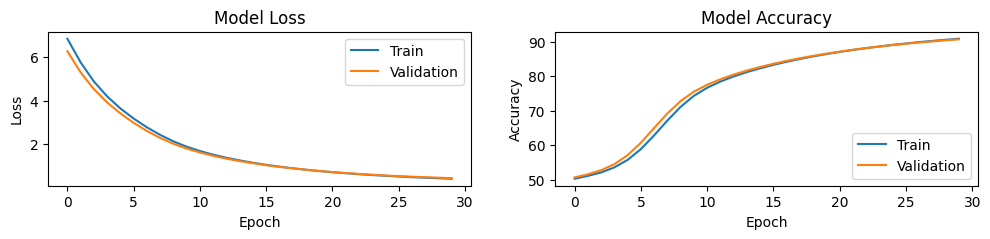

In [85]:
# Plot training & validation loss values
plt.figure(figsize=(12, 2))
plt.subplot(1, 2, 1)
plt.plot(list_train_loss, label='Train')
plt.plot(list_val_loss, label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(list_train_acc, label='Train')
plt.plot(list_val_acc, label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.show()

I can observe that over the course of the epochs, both my training and validation losses decrease as expected. At the same time, my training and validation accuracies are increasing which shows improvement in the model training. This is consistent with the results I was expecting.

I will now write a function `save_model` that saves my Word2Vec model’s embeddings in a file so that they can be loaded later for the classification task.

In [86]:
def save_model(model, d, R, K, B, E):
    file_name = f"model_dim-{d}_radius-{R}_ratio-{K}-batch-{B}-epoch-{E}.ckpt"
    embeddings = model.target_embeddings.weight.data
    checkpoint = {
        'embedding_words.weight': embeddings
    }
    torch.save(checkpoint, file_name)

save_model(model_word2vec, d, R, K, B, E)

---
---

# Classification Task

In this section I will experiment with the classification task of the lab, augmented with my Word2Vec model. This task utilizes a Convolutional model that I have defined as `Conv1dClassifier`, which uses the `nn.Conv1d` module of torch. I will first train this model with an initialization using the embeddings saved from my `Word2Vec` model. After training this model, I will compare it to a simple model, trained with some randomly chosen intialization parameters. Comparing the results of the two models will give some insight into how performant the embeddings from my first model are.

First, I will go through the process of quickly pre-processing the data again to prepare it for my convolutional classifier model.

In [87]:
dataset = load_dataset("scikit-learn/imdb", split="train")
print(dataset)

def preprocessing_fn(x, tokenizer):
    x["review_ids"] = tokenizer(
        x["review"],
        add_special_tokens=False,
        truncation=True,
        max_length=256,
        padding=False,
        return_attention_mask=False,
    )["input_ids"]
    x["label"] = 0 if x["sentiment"] == "negative" else 1
    return x

n_samples = 5000  # the number of training example
# We first shuffle the data !
dataset = dataset.shuffle(seed=seed)
# Select 5000 samples
dataset = dataset.select(range(n_samples))
# Tokenize the dataset
dataset = dataset.map(lambda x: preprocessing_fn(x, tokenizer), batched=False)
# Remove useless columns
dataset = dataset.remove_columns(['review','sentiment'])
# Split the train and validation
dataset = dataset.train_test_split(train_size=.8, seed=seed)
train_set = dataset['train']
valid_set = dataset['test']

class DataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, batch):
        # `batch` is a list of dictionary with keys "review_ids" and "label".
        features = [{"input_ids": x["review_ids"]} for x in batch]
        features = self.tokenizer.pad(
            features, padding="max_length", max_length=256, return_tensors="pt"
        )
        labels = torch.tensor([x["label"] for x in batch])  # No need for [:, None]
        return {"review_ids": features["input_ids"], "label": labels}

data_collator = DataCollator(tokenizer)
batch_size = 64
train_dataloader_conv = DataLoader(
    train_set, batch_size=batch_size, collate_fn=data_collator
)
valid_dataloader_conv = DataLoader(
    valid_set, batch_size=batch_size, collate_fn=data_collator
)
n_valid = len(valid_set)
n_train = len(train_set)

Dataset({
    features: ['review', 'sentiment'],
    num_rows: 50000
})


Now I will load the embeddings of my `Word2Vec` model using the `load_model` function defined below. This will access the embeddings weights saved in a checkpoint file and return them as an `nn.Embedding` layer that I can use in the convolutional classifier model.

In [88]:
def load_model(word2vec_path, freeze=False):
    word2vec_checkpoint = torch.load(word2vec_path)
    pretrained_embeddings  = word2vec_checkpoint['embedding_words.weight']
    num_embeddings, embedding_dim = pretrained_embeddings.size()
    embedding_layer = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=freeze)
    return embedding_layer, embedding_dim

# Load Word2Vec model
checkpoint_path = rf'/content/model_dim-{d}_radius-{R}_ratio-{K}-batch-{B}-epoch-{E}.ckpt'
word2vec_embeddings, embedding_dim = load_model(checkpoint_path)

Below, I am creating the model class for my first Convolutional classifier model which will be initialized using the loaded embeddings from my `Word2Vec` model. I will call this model `Conv1dClassifier_with_word2vec_embeddings` in order to properly identify it. For `self.embedding`, I am directly loading the embeddings instead of defining a new embedding layer.

In [89]:
class Conv1dClassifier_with_word2vec_embeddings(nn.Module):
    """A text classifier:
    - input = minibatch
    - output = probability associated to a binary classification task
    - vocab_size: the number of words in the vocabulary we want to embed
    - embedding_dim: size of the word vectors
    """

    def __init__(self, vocab_size, embedding_dim, word2vec_embeddings, feature_size=100, kernel_size=3):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.feature_size = feature_size

        self.embedding = word2vec_embeddings

        self.conv = nn.Conv1d(in_channels=self.embedding_dim, out_channels=self.feature_size, kernel_size=kernel_size, padding=1)
        self.relu = nn.ReLU()
        self.pooling_layer = nn.AdaptiveMaxPool1d(output_size=2)
        self.flatten_layer = nn.Flatten()
        self.linear_layer = nn.LazyLinear(out_features=2)
        self.softmax_layer = nn.Softmax(dim=1)

    def forward(self, input_ids):
        embedding_output = self.embedding(input_ids.to(device))
        conv_output = self.conv(embedding_output.permute(0, 2, 1))
        pooling_output = self.pooling_layer(self.relu(conv_output))
        flattened_output = self.flatten_layer(pooling_output)
        linear_output = self.linear_layer(flattened_output)
        return linear_output

Now that I have defined my model, I can train it to obtain the training loss, training accuracy, validation loss, and validation accuracy of the classification model using the `Word2Vec` model embeddings.

In [90]:
def train_with_embeddings(train_dataloader_conv, valid_dataloader_conv,
                          word2vec_embeddings, embedding_dim, num_epochs):
  ## Define the training loss
  loss_function = nn.CrossEntropyLoss()
  ## The optimizer
  model_conv_w_emb = Conv1dClassifier_with_word2vec_embeddings(
      vocab_size=tokenizer.vocab_size, embedding_dim=embedding_dim,
      word2vec_embeddings=word2vec_embeddings
  )
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model_conv_w_emb.to(device)

  optimizer = torch.optim.Adam(params=model_conv_w_emb.parameters(), lr=1e-2)

  list_val_acc_conv_emb = []
  list_train_acc_conv_emb = []
  list_train_loss_conv_emb = []
  list_val_loss_conv_emb = []

  for e in range(num_epochs):
      # Training
      model_conv_w_emb.train()
      train_loss_per_epoch = []
      train_correct = 0
      train_total = 0
      for batch in tqdm(train_dataloader_conv):
          inputs, targets = batch['review_ids'].to(device), batch['label'].to(device)
          optimizer.zero_grad()
          outputs = model_conv_w_emb(inputs)
          loss = loss_function(outputs, targets)
          loss.backward()
          optimizer.step()

          train_loss_per_epoch.append(loss.item())
          _, predicted = torch.max(outputs, 1)
          train_total += targets.size(0)
          train_correct += (predicted == targets).sum().item()

      train_accuracy = 100 * train_correct / train_total

      # Validation
      model_conv_w_emb.eval()
      valid_loss_per_epoch = []
      valid_correct = 0
      valid_total = 0
      with torch.no_grad():
          for batch in tqdm(valid_dataloader_conv):
              inputs, targets = batch['review_ids'].to(device), batch['label'].to(device)
              outputs = model_conv_w_emb(inputs)
              loss = loss_function(outputs, targets)
              valid_loss_per_epoch.append(loss.item())
              _, predicted = torch.max(outputs, 1)
              valid_total += targets.size(0)
              valid_correct += (predicted == targets).sum().item()

      valid_accuracy = 100 * valid_correct / valid_total

      print('-' * 100)
      print(f'Epoch: {e+1}')
      print(f'Train Loss: {np.mean(train_loss_per_epoch):.4f} | Train Accuracy: {train_accuracy:.2f}%')
      print(f'Valid Loss: {np.mean(valid_loss_per_epoch):.4f} | Valid Accuracy: {valid_accuracy:.2f}%')

      list_val_acc_conv_emb.append(valid_accuracy)
      list_train_acc_conv_emb.append(train_accuracy)
      list_train_loss_conv_emb.append(np.mean(train_loss_per_epoch))
      list_val_loss_conv_emb.append(np.mean(valid_loss_per_epoch))

  return list_val_acc_conv_emb, list_train_acc_conv_emb, list_train_loss_conv_emb, list_val_loss_conv_emb

list_val_acc_conv_emb, list_train_acc_conv_emb, list_train_loss_conv_emb, list_val_loss_conv_emb = train_with_embeddings(
    train_dataloader_conv, valid_dataloader_conv, word2vec_embeddings, embedding_dim, num_epochs=3)

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Epoch: 1
Train Loss: 0.7569 | Train Accuracy: 53.52%
Valid Loss: 0.6833 | Valid Accuracy: 54.60%


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Epoch: 2
Train Loss: 0.3153 | Train Accuracy: 86.22%
Valid Loss: 0.8689 | Valid Accuracy: 65.70%


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Epoch: 3
Train Loss: 0.0393 | Train Accuracy: 98.80%
Valid Loss: 1.5679 | Valid Accuracy: 62.80%


I now have the loss and accuracy results for both the training and validation for my convolutional model using the `Word2Vec` model embeddings. I will use these later on to produce graphical representations in order to compare this model to the convolutional model without the embeddings initialization.

Now, I will create the second convolutional classifier model without the `Word2Vec` model initialization in order to compare their results. This model will be named `Conv1dClassifier` and will use an embedding layer `nn.Embedding` which will be parameterized by the randomly chosen `vocab_size` and `embedding_dim` parameters. This can be seen below when defining the embedding layer `self.embedding` in the model. Once trained, this model should produce different results than the previous convolutional model.

In [91]:
class Conv1dClassifier(nn.Module):
    """A text classifier:
    - input = minibatch
    - output = probability associated to a binary classification task
    - vocab_size: the number of words in the vocabulary we want to embed
    - embedding_dim: size of the word vectors
    """

    def __init__(self, vocab_size, embedding_dim, feature_size=100, kernel_size=3):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.feature_size = feature_size

        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=self.embedding_dim)

        self.conv = nn.Conv1d(in_channels=self.embedding_dim, out_channels=self.feature_size, kernel_size=kernel_size, padding=1)
        self.relu = nn.ReLU()
        self.pooling_layer = nn.AdaptiveMaxPool1d(output_size=2)
        self.flatten_layer = nn.Flatten()
        self.linear_layer = nn.LazyLinear(out_features=2)
        self.softmax_layer = nn.Softmax(dim=1)

    def forward(self, input_ids):
        embedding_output = self.embedding(input_ids.to(device))
        conv_output = self.conv(embedding_output.mT)
        pooling_output = self.pooling_layer(self.relu(conv_output))
        flattened_output = self.flatten_layer(pooling_output)
        linear_output = self.linear_layer(flattened_output)
        return linear_output

Just like with the first convolutional model, now that I have defined my new classification model, I can train it to obtain the training loss, training accuracy, validation loss, and validation accuracy.

In [92]:
## Define the training loss
loss_function = nn.CrossEntropyLoss()
## The optimizer
model_conv = Conv1dClassifier(
    vocab_size=tokenizer.vocab_size, embedding_dim=100
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_conv.to(device)

optimizer = torch.optim.Adam(params=model_conv.parameters(), lr=1e-2)

num_epochs = 3

list_val_acc_conv = []
list_train_acc_conv = []
list_train_loss_conv = []
list_val_loss_conv = []

for e in range(num_epochs):
    # Training
    model_conv.train()
    train_loss_per_epoch = []
    train_correct = 0
    train_total = 0
    for batch in tqdm(train_dataloader_conv):
        inputs, targets = batch['review_ids'].to(device), batch['label'].to(device)
        optimizer.zero_grad()
        outputs = model_conv(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss_per_epoch.append(loss.item())
        _, predicted = torch.max(outputs, 1)
        train_total += targets.size(0)
        train_correct += (predicted == targets).sum().item()

    train_accuracy = 100 * train_correct / train_total

    # Validation
    model_conv.eval()
    valid_loss_per_epoch = []
    valid_correct = 0
    valid_total = 0
    with torch.no_grad():
        for batch in tqdm(valid_dataloader_conv):
            inputs, targets = batch['review_ids'].to(device), batch['label'].to(device)
            outputs = model_conv(inputs)
            loss = loss_function(outputs, targets)
            valid_loss_per_epoch.append(loss.item())
            _, predicted = torch.max(outputs, 1)
            valid_total += targets.size(0)
            valid_correct += (predicted == targets).sum().item()

    valid_accuracy = 100 * valid_correct / valid_total

    print('-' * 100)
    print(f'Epoch: {e+1}')
    print(f'Train Loss: {np.mean(train_loss_per_epoch):.4f} | Train Accuracy: {train_accuracy:.2f}%')
    print(f'Valid Loss: {np.mean(valid_loss_per_epoch):.4f} | Valid Accuracy: {valid_accuracy:.2f}%')

    list_val_acc_conv.append(valid_accuracy)
    list_train_acc_conv.append(train_accuracy)
    list_train_loss_conv.append(np.mean(train_loss_per_epoch))
    list_val_loss_conv.append(np.mean(valid_loss_per_epoch))

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Epoch: 1
Train Loss: 0.8068 | Train Accuracy: 57.27%
Valid Loss: 0.5821 | Valid Accuracy: 70.00%


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Epoch: 2
Train Loss: 0.4066 | Train Accuracy: 81.15%
Valid Loss: 0.6925 | Valid Accuracy: 71.20%


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Epoch: 3
Train Loss: 0.2033 | Train Accuracy: 91.30%
Valid Loss: 0.6007 | Valid Accuracy: 76.80%


I now have the loss and accuracy results for both the training and validation for my convolutional model without the embeddings initialization. I will now use these along with the previous model results to produce a graphical representation which will allow me to compare the two models.

### Comparing Results

Below is the code used to make the graphical comparison of the metric results of both models.

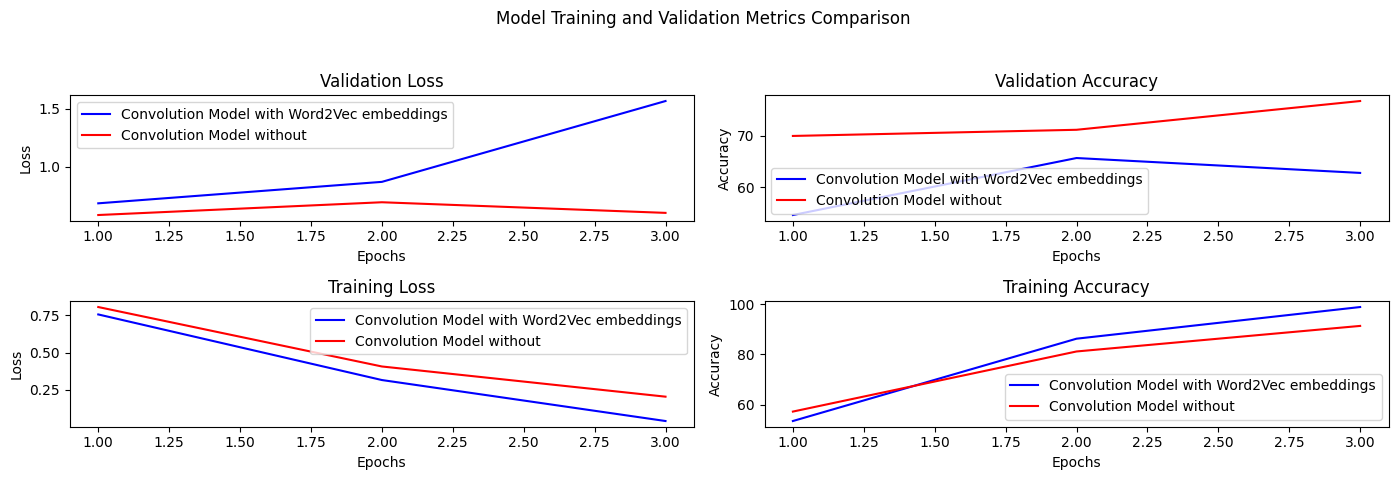

In [93]:
def plot_model_comparisons(model1_data, model2_data, epochs):
    fig, axes = plt.subplots(2, 2, figsize=(14, 5))
    fig.suptitle('Model Training and Validation Metrics Comparison')

    # Unpack data
    val_loss1, val_acc1, train_loss1, train_acc1 = model1_data
    val_loss2, val_acc2, train_loss2, train_acc2 = model2_data

    # Epochs array
    epoch_range = list(range(1, epochs + 1))

    # Validation Loss
    axes[0, 0].plot(epoch_range, val_loss1, 'b-', label='Convolution Model with Word2Vec embeddings')
    axes[0, 0].plot(epoch_range, val_loss2, 'r-', label='Convolution Model without')
    axes[0, 0].set_title('Validation Loss')
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()

    # Validation Accuracy
    axes[0, 1].plot(epoch_range, val_acc1, 'b-', label='Convolution Model with Word2Vec embeddings')
    axes[0, 1].plot(epoch_range, val_acc2, 'r-', label='Convolution Model without')
    axes[0, 1].set_title('Validation Accuracy')
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()

    # Training Loss
    axes[1, 0].plot(epoch_range, train_loss1, 'b-', label='Convolution Model with Word2Vec embeddings')
    axes[1, 0].plot(epoch_range, train_loss2, 'r-', label='Convolution Model without')
    axes[1, 0].set_title('Training Loss')
    axes[1, 0].set_xlabel('Epochs')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].legend()

    # Training Accuracy
    axes[1, 1].plot(epoch_range, train_acc1, 'b-', label='Convolution Model with Word2Vec embeddings')
    axes[1, 1].plot(epoch_range, train_acc2, 'r-', label='Convolution Model without')
    axes[1, 1].set_title('Training Accuracy')
    axes[1, 1].set_xlabel('Epochs')
    axes[1, 1].set_ylabel('Accuracy')
    axes[1, 1].legend()

    # Layout adjustment
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Show plot
    plt.show()

# Example data
model1_data = (list_val_loss_conv_emb, list_val_acc_conv_emb, list_train_loss_conv_emb, list_train_acc_conv_emb)
model2_data = (list_val_loss_conv, list_val_acc_conv, list_train_loss_conv, list_train_acc_conv)

# Call function
plot_model_comparisons(model1_data, model2_data, num_epochs)

As can be observed from the above graphs, after training for 3 epochs, using the embeddings of Word2Vec as initialization for the convolutional model does not improve performance, and in fact becomes worse than a model with simple initialization. This is not expected, but shows that the Word2Vec embeddings are not appropriate for a classification model. Aside from the validation loss, the other metrics are behaving as expected, with loss decreasing and accuracy increasing over the epochs. After multiple different experiments with a consistent random seed value, I noticed no change in the performance trend of these models.  

### Ablation Study

In my ablation study, I decided to test the influence of some parameters of the Word2Vec model on the classification task. For this, I set up different configurations for my Word2Vec model, and decided to test specifically different embedding dimensions and different batch sizes. For embeddding dimensions, I tested values of 50 and 100, and for batches, I decided to test values of 16 and 32, which is recommend for a smaller dataset such as the one I am using. Additionally, I added a testing of different epochs, but this will only be used to configure the Word2Vec model, and not the convolutional models.

In [ ]:
# Define different configurations for Word2Vec
configurations = [
    {'embedding_size': 50, 'batch': 16, 'radius': 4, 'ratio': 6},
    {'embedding_size': 50, 'batch': 32, 'radius': 4, 'ratio': 10},
    {'embedding_size': 100, 'batch': 32, 'radius': 6, 'ratio': 8},
    {'embedding_size': 100, 'batch': 64, 'radius': 6, 'ratio': 10},
    {'embedding_size': 100, 'batch': 16, 'radius': 8, 'ratio': 6},
    {'embedding_size': 100, 'batch': 32, 'radius': 4, 'ratio': 10},
    {'embedding_size': 200, 'batch': 32, 'radius': 6, 'ratio': 8},
    {'embedding_size': 200, 'batch': 64, 'radius': 8, 'ratio': 10}
]

results = []

for config in configurations:
    embs = config['embedding_size']
    epochs = 30
    batch_size = config['batch']
    R = config['radius']
    K = config['ratio']
    samples = 50

    # Pre-process data for Word2Vec using new configurations
    dataset = load_dataset("scikit-learn/imdb", split="train")
    shuffled_dataset = dataset.shuffle(seed=seed)
    small_dataset = shuffled_dataset.select(range(samples))
    tok_dataset = small_dataset.map(preprocessing_fn,
                                    fn_kwargs={'tokenizer': tokenizer})
    tok_dataset = tok_dataset.select_columns(['review_ids', 'label'])
    tok_dataset = tok_dataset.train_test_split(test_size=0.2, seed=seed)
    document_train_set = tok_dataset['train']
    document_valid_set = tok_dataset['test']

    flat_train_words, flat_train_contexts = flatten_dataset_to_list(document_train_set, R)
    flat_valid_words, flat_valid_contexts = flatten_dataset_to_list(document_valid_set, R)

    train_set = TextDataset(flat_train_words, flat_train_contexts)
    valid_set = TextDataset(flat_valid_words, flat_valid_contexts)

    train_dataloader = DataLoader(
        train_set, batch_size=batch_size, collate_fn=lambda x: collate_fn(x, R, K)
    )
    valid_dataloader = DataLoader(
        valid_set, batch_size=batch_size, collate_fn=lambda x: collate_fn(x, R, K)
    )

    # Train Word2Vec with the current configuration
    model_word2vec = Word2Vec(vocab_size, embs)
    model_word2vec.to(device)
    train_model(model_word2vec, train_dataloader, valid_dataloader, epochs, optimizer, device)

    # Save the embeddings
    save_model(model_word2vec, embs, R, K, batch_size, epochs)

    # Load the embeddings into the Conv1dClassifier using load_model
    checkpoint_path = rf'/content/model_dim-{embs}_radius-{R}_ratio-{K}-batch-{batch_size}-epoch-{epochs}.ckpt'
    word2vec_embeddings, embedding_dim = load_model(checkpoint_path)

    # Initialize Conv1dClassifier model with embeddings
    model_conv = Conv1dClassifier_with_word2vec_embeddings(
      vocab_size=tokenizer.vocab_size, embedding_dim=embedding_dim,
      word2vec_embeddings=word2vec_embeddings
    )

    # Re-process data and Redefine dataloaders for Conv1dClassifier with new configurations
    dataset_clas = load_dataset("scikit-learn/imdb", split="train")
    n_samples = 5000  # the number of training example
    dataset_clas = dataset_clas.shuffle(seed=seed)
    dataset_clas = dataset_clas.select(range(n_samples))
    dataset_clas = dataset_clas.map(lambda x: preprocessing_fn(x, tokenizer), batched=False)
    dataset_clas = dataset_clas.remove_columns(['review','sentiment'])
    dataset_clas = dataset_clas.train_test_split(train_size=.8, seed=seed)
    train_set = dataset_clas['train']
    valid_set = dataset_clas['test']

    data_collator = DataCollator(tokenizer)
    train_dataloader_conv_ab = DataLoader(
        train_set, batch_size=batch_size, collate_fn=data_collator
    )
    valid_dataloader_conv_ab = DataLoader(
        valid_set, batch_size=batch_size, collate_fn=data_collator
    )

    # Train the Conv1dClassifier
    list_val_acc, list_train_acc, list_train_loss, list_val_loss = train_with_embeddings(
        train_dataloader_conv_ab, valid_dataloader_conv_ab, word2vec_embeddings, embedding_dim, num_epochs=3)

    # Evaluate the classifier and store metrics
    results.append((config, list_train_loss[-1], list_val_loss[-1], list_train_acc[-1], list_val_acc[-1]))

  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 1
	 - Train loss: 3.6539 Train acc: 50.0445 Val loss: 3.6016 Val acc: 49.9218


  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 2
	 - Train loss: 3.6345 Train acc: 49.9982 Val loss: 3.5912 Val acc: 50.0431


  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 3
	 - Train loss: 3.6317 Train acc: 49.9518 Val loss: 3.5903 Val acc: 50.1152


  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 4
	 - Train loss: 3.6327 Train acc: 49.8872 Val loss: 3.6027 Val acc: 49.9078


  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 5
	 - Train loss: 3.6166 Train acc: 50.0512 Val loss: 3.5961 Val acc: 49.7715


  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 6
	 - Train loss: 3.6303 Train acc: 50.0042 Val loss: 3.5707 Val acc: 50.0752


  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 7
	 - Train loss: 3.6380 Train acc: 50.0358 Val loss: 3.5919 Val acc: 50.1764


  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 8
	 - Train loss: 3.6319 Train acc: 50.0438 Val loss: 3.5889 Val acc: 49.8898


  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 9
	 - Train loss: 3.6103 Train acc: 50.1020 Val loss: 3.6359 Val acc: 49.9048


  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 10
	 - Train loss: 3.6474 Train acc: 49.9419 Val loss: 3.5642 Val acc: 49.8797


  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 11
	 - Train loss: 3.6320 Train acc: 50.0081 Val loss: 3.5708 Val acc: 50.1092


  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 12
	 - Train loss: 3.6311 Train acc: 49.9663 Val loss: 3.6224 Val acc: 49.9559


  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 13
	 - Train loss: 3.6054 Train acc: 49.9693 Val loss: 3.5951 Val acc: 49.9549


  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 14
	 - Train loss: 3.6516 Train acc: 49.9931 Val loss: 3.6399 Val acc: 49.8427


  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 15
	 - Train loss: 3.6375 Train acc: 49.9735 Val loss: 3.6108 Val acc: 49.6192


  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 16
	 - Train loss: 3.6304 Train acc: 49.9592 Val loss: 3.6007 Val acc: 49.8998


  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 17
	 - Train loss: 3.6332 Train acc: 49.9336 Val loss: 3.6576 Val acc: 49.8447


  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 18
	 - Train loss: 3.6426 Train acc: 49.8999 Val loss: 3.6931 Val acc: 49.9910


  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 19
	 - Train loss: 3.6408 Train acc: 50.0104 Val loss: 3.6066 Val acc: 50.0110


  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 20
	 - Train loss: 3.6454 Train acc: 49.9361 Val loss: 3.6151 Val acc: 49.9218


  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 21
	 - Train loss: 3.6196 Train acc: 50.0747 Val loss: 3.6621 Val acc: 49.9820


  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 22
	 - Train loss: 3.6419 Train acc: 50.1949 Val loss: 3.6240 Val acc: 49.9609


  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 23
	 - Train loss: 3.6361 Train acc: 49.9917 Val loss: 3.5746 Val acc: 49.9188


  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 24
	 - Train loss: 3.6310 Train acc: 49.9714 Val loss: 3.6064 Val acc: 49.8707


  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 25
	 - Train loss: 3.6369 Train acc: 49.9343 Val loss: 3.6237 Val acc: 49.9369


  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 26
	 - Train loss: 3.6341 Train acc: 50.0275 Val loss: 3.5405 Val acc: 49.9689


  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 27
	 - Train loss: 3.6042 Train acc: 49.9871 Val loss: 3.5864 Val acc: 49.9018


  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 28
	 - Train loss: 3.6360 Train acc: 49.9601 Val loss: 3.5936 Val acc: 49.8106


  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 29
	 - Train loss: 3.6322 Train acc: 50.0609 Val loss: 3.6321 Val acc: 49.9439


  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 30
	 - Train loss: 3.6618 Train acc: 49.9647 Val loss: 3.6023 Val acc: 50.0271


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Epoch: 1
Train Loss: 0.7904 | Train Accuracy: 60.33%
Valid Loss: 0.5577 | Valid Accuracy: 73.00%


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Epoch: 2
Train Loss: 0.6280 | Train Accuracy: 76.08%
Valid Loss: 0.9708 | Valid Accuracy: 70.90%


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Epoch: 3
Train Loss: 0.4478 | Train Accuracy: 86.97%
Valid Loss: 1.6617 | Valid Accuracy: 71.40%


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 1
	 - Train loss: 3.6460 Train acc: 50.1191 Val loss: 3.6738 Val acc: 49.8304


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 2
	 - Train loss: 3.6732 Train acc: 49.8933 Val loss: 3.6391 Val acc: 50.1945


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 3
	 - Train loss: 3.6749 Train acc: 49.9627 Val loss: 3.6489 Val acc: 49.8961


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 4
	 - Train loss: 3.6813 Train acc: 49.9262 Val loss: 3.6650 Val acc: 50.0434


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 5
	 - Train loss: 3.6702 Train acc: 49.9770 Val loss: 3.6703 Val acc: 49.8482


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 6
	 - Train loss: 3.6590 Train acc: 49.8767 Val loss: 3.6193 Val acc: 49.8961


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 7
	 - Train loss: 3.6802 Train acc: 49.9734 Val loss: 3.6108 Val acc: 49.9541


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 8
	 - Train loss: 3.6489 Train acc: 49.9507 Val loss: 3.6719 Val acc: 49.9936


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 9
	 - Train loss: 3.6793 Train acc: 49.9758 Val loss: 3.6063 Val acc: 50.3648


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 10
	 - Train loss: 3.6858 Train acc: 49.9262 Val loss: 3.6366 Val acc: 50.1224


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 11
	 - Train loss: 3.6636 Train acc: 50.0367 Val loss: 3.6482 Val acc: 50.0555


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 12
	 - Train loss: 3.6471 Train acc: 50.0725 Val loss: 3.7447 Val acc: 49.8348


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 13
	 - Train loss: 3.6628 Train acc: 49.9379 Val loss: 3.6743 Val acc: 50.0026


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 14
	 - Train loss: 3.6692 Train acc: 49.9862 Val loss: 3.6815 Val acc: 49.8540


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 15
	 - Train loss: 3.6403 Train acc: 50.0016 Val loss: 3.6581 Val acc: 49.9815


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 16
	 - Train loss: 3.6662 Train acc: 49.9458 Val loss: 3.6646 Val acc: 49.9503


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 17
	 - Train loss: 3.6760 Train acc: 49.9959 Val loss: 3.6881 Val acc: 50.1173


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 18
	 - Train loss: 3.6821 Train acc: 49.9908 Val loss: 3.6457 Val acc: 49.8973


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 19
	 - Train loss: 3.6728 Train acc: 49.9483 Val loss: 3.6650 Val acc: 50.1116


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 20
	 - Train loss: 3.6374 Train acc: 49.9817 Val loss: 3.7323 Val acc: 49.7864


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 21
	 - Train loss: 3.6766 Train acc: 50.0279 Val loss: 3.6354 Val acc: 50.0089


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 22
	 - Train loss: 3.6598 Train acc: 50.1048 Val loss: 3.6531 Val acc: 50.0083


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 23
	 - Train loss: 3.6563 Train acc: 50.0254 Val loss: 3.6543 Val acc: 49.8827


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 24
	 - Train loss: 3.6628 Train acc: 49.8547 Val loss: 3.6173 Val acc: 49.8744


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 25
	 - Train loss: 3.6556 Train acc: 50.0264 Val loss: 3.6554 Val acc: 50.1779


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 26
	 - Train loss: 3.6733 Train acc: 49.9709 Val loss: 3.6581 Val acc: 50.0121


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 27
	 - Train loss: 3.6609 Train acc: 50.0179 Val loss: 3.6429 Val acc: 49.9656


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 28
	 - Train loss: 3.6862 Train acc: 49.9627 Val loss: 3.5955 Val acc: 50.0580


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 29
	 - Train loss: 3.6916 Train acc: 49.9105 Val loss: 3.6385 Val acc: 49.8259


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 30
	 - Train loss: 3.6678 Train acc: 49.9676 Val loss: 3.6166 Val acc: 49.9401


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Epoch: 1
Train Loss: 0.7749 | Train Accuracy: 58.48%
Valid Loss: 0.7797 | Valid Accuracy: 60.80%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Epoch: 2
Train Loss: 0.5068 | Train Accuracy: 76.58%
Valid Loss: 1.3742 | Valid Accuracy: 60.80%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Epoch: 3
Train Loss: 0.3272 | Train Accuracy: 87.58%
Valid Loss: 0.7295 | Valid Accuracy: 75.50%


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 1
	 - Train loss: 7.2985 Train acc: 49.9312 Val loss: 7.2241 Val acc: 49.9236


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 2
	 - Train loss: 7.2722 Train acc: 50.0457 Val loss: 7.2325 Val acc: 49.9787


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 3
	 - Train loss: 7.2727 Train acc: 49.9638 Val loss: 7.1841 Val acc: 49.9278


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 4
	 - Train loss: 7.2939 Train acc: 50.0337 Val loss: 7.1739 Val acc: 50.1621


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 5
	 - Train loss: 7.2764 Train acc: 49.9945 Val loss: 7.2362 Val acc: 50.0514


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 6
	 - Train loss: 7.2727 Train acc: 49.9974 Val loss: 7.2692 Val acc: 49.9522


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 7
	 - Train loss: 7.2648 Train acc: 49.9848 Val loss: 7.1134 Val acc: 49.8602


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 8
	 - Train loss: 7.2286 Train acc: 50.0518 Val loss: 7.2887 Val acc: 49.9137


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 9
	 - Train loss: 7.2606 Train acc: 49.9545 Val loss: 7.2381 Val acc: 50.0889


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 10
	 - Train loss: 7.2688 Train acc: 49.9530 Val loss: 7.2250 Val acc: 50.0275


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 11
	 - Train loss: 7.2835 Train acc: 50.0158 Val loss: 7.1771 Val acc: 50.0675


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 12
	 - Train loss: 7.2545 Train acc: 50.0176 Val loss: 7.2964 Val acc: 49.8810


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 13
	 - Train loss: 7.2665 Train acc: 49.9471 Val loss: 7.2185 Val acc: 49.9678


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 14
	 - Train loss: 7.2379 Train acc: 49.9633 Val loss: 7.1762 Val acc: 49.9543


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 15
	 - Train loss: 7.2336 Train acc: 50.0327 Val loss: 7.1850 Val acc: 50.0946


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 16
	 - Train loss: 7.2786 Train acc: 49.9531 Val loss: 7.2075 Val acc: 49.9117


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 17
	 - Train loss: 7.2361 Train acc: 50.0134 Val loss: 7.2346 Val acc: 50.0156


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 18
	 - Train loss: 7.2688 Train acc: 49.9286 Val loss: 7.2346 Val acc: 50.1315


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 19
	 - Train loss: 7.2308 Train acc: 50.0159 Val loss: 7.1750 Val acc: 49.8774


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 20
	 - Train loss: 7.2743 Train acc: 49.9096 Val loss: 7.2129 Val acc: 49.9725


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 21
	 - Train loss: 7.2629 Train acc: 50.0123 Val loss: 7.1866 Val acc: 49.8519


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 22
	 - Train loss: 7.2752 Train acc: 49.9896 Val loss: 7.2522 Val acc: 49.9376


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 23
	 - Train loss: 7.2641 Train acc: 49.8684 Val loss: 7.2488 Val acc: 49.9086


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 24
	 - Train loss: 7.2556 Train acc: 50.0178 Val loss: 7.2276 Val acc: 49.9163


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 25
	 - Train loss: 7.2681 Train acc: 50.0372 Val loss: 7.2803 Val acc: 50.0390


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 26
	 - Train loss: 7.3029 Train acc: 49.8590 Val loss: 7.2338 Val acc: 49.8327


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 27
	 - Train loss: 7.2687 Train acc: 49.9925 Val loss: 7.2095 Val acc: 49.9366


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 28
	 - Train loss: 7.2682 Train acc: 50.0129 Val loss: 7.0735 Val acc: 50.0307


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 29
	 - Train loss: 7.2720 Train acc: 49.9861 Val loss: 7.1946 Val acc: 49.9127


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 30
	 - Train loss: 7.2376 Train acc: 50.0318 Val loss: 7.1894 Val acc: 50.2837


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Epoch: 1
Train Loss: 0.8469 | Train Accuracy: 58.00%
Valid Loss: 0.5948 | Valid Accuracy: 70.60%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Epoch: 2
Train Loss: 0.5237 | Train Accuracy: 76.12%
Valid Loss: 0.9765 | Valid Accuracy: 67.40%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Epoch: 3
Train Loss: 0.3385 | Train Accuracy: 88.72%
Valid Loss: 0.9217 | Valid Accuracy: 75.70%


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 1
	 - Train loss: 7.4791 Train acc: 49.9499 Val loss: 7.4386 Val acc: 49.8006


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 2
	 - Train loss: 7.4302 Train acc: 49.9087 Val loss: 7.4268 Val acc: 49.8278


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 3
	 - Train loss: 7.4895 Train acc: 49.9114 Val loss: 7.5184 Val acc: 50.0544


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 4
	 - Train loss: 7.4814 Train acc: 49.8459 Val loss: 7.5033 Val acc: 49.9354


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 5
	 - Train loss: 7.4436 Train acc: 49.8563 Val loss: 7.4787 Val acc: 50.1029


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 6
	 - Train loss: 7.4519 Train acc: 49.9527 Val loss: 7.4369 Val acc: 49.9367


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 7
	 - Train loss: 7.4748 Train acc: 49.9059 Val loss: 7.4812 Val acc: 49.7747


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 8
	 - Train loss: 7.4217 Train acc: 49.9541 Val loss: 7.4513 Val acc: 49.9426


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 9
	 - Train loss: 7.4937 Train acc: 49.8714 Val loss: 7.5192 Val acc: 49.6973


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 10
	 - Train loss: 7.4539 Train acc: 49.9352 Val loss: 7.4314 Val acc: 50.0251


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 11
	 - Train loss: 7.4459 Train acc: 49.9211 Val loss: 7.4450 Val acc: 50.0974


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 12
	 - Train loss: 7.4847 Train acc: 49.9262 Val loss: 7.4715 Val acc: 49.9282


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 13
	 - Train loss: 7.4495 Train acc: 49.9279 Val loss: 7.4620 Val acc: 49.8988


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 14
	 - Train loss: 7.4412 Train acc: 49.8585 Val loss: 7.4546 Val acc: 49.8848


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 15
	 - Train loss: 7.4732 Train acc: 49.9984 Val loss: 7.5043 Val acc: 49.9592


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 16
	 - Train loss: 7.4341 Train acc: 49.9838 Val loss: 7.3924 Val acc: 50.1424


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 17
	 - Train loss: 7.4309 Train acc: 49.9652 Val loss: 7.4158 Val acc: 49.8380


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 18
	 - Train loss: 7.4559 Train acc: 49.9398 Val loss: 7.4659 Val acc: 49.9294


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 19
	 - Train loss: 7.4747 Train acc: 49.8349 Val loss: 7.5334 Val acc: 49.7509


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 20
	 - Train loss: 7.4693 Train acc: 49.9060 Val loss: 7.4169 Val acc: 49.9056


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 21
	 - Train loss: 7.4602 Train acc: 49.8932 Val loss: 7.5190 Val acc: 49.8168


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 22
	 - Train loss: 7.4920 Train acc: 49.9158 Val loss: 7.5375 Val acc: 49.7462


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 23
	 - Train loss: 7.4998 Train acc: 49.8111 Val loss: 7.4371 Val acc: 49.9392


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 24
	 - Train loss: 7.4561 Train acc: 49.9317 Val loss: 7.4044 Val acc: 49.9885


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 25
	 - Train loss: 7.5014 Train acc: 49.8350 Val loss: 7.4819 Val acc: 49.8933


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 26
	 - Train loss: 7.4386 Train acc: 49.9829 Val loss: 7.4271 Val acc: 49.9307


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 27
	 - Train loss: 7.4608 Train acc: 49.9105 Val loss: 7.4569 Val acc: 49.7381


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 28
	 - Train loss: 7.5001 Train acc: 49.9334 Val loss: 7.3744 Val acc: 49.9090


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 29
	 - Train loss: 7.4495 Train acc: 49.9067 Val loss: 7.4128 Val acc: 50.1199


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 30
	 - Train loss: 7.4681 Train acc: 49.9219 Val loss: 7.4398 Val acc: 50.0391


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Epoch: 1
Train Loss: 0.7967 | Train Accuracy: 57.88%
Valid Loss: 0.5650 | Valid Accuracy: 70.70%


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Epoch: 2
Train Loss: 0.4043 | Train Accuracy: 82.35%
Valid Loss: 0.9165 | Valid Accuracy: 66.10%


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Epoch: 3
Train Loss: 0.2613 | Train Accuracy: 89.22%
Valid Loss: 0.6019 | Valid Accuracy: 78.10%


  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 1
	 - Train loss: 7.4307 Train acc: 50.0754 Val loss: 7.4769 Val acc: 50.0180


  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 2
	 - Train loss: 7.4336 Train acc: 50.1498 Val loss: 7.4409 Val acc: 49.9674


  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 3
	 - Train loss: 7.3945 Train acc: 50.1715 Val loss: 7.4308 Val acc: 50.0701


  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 4
	 - Train loss: 7.4087 Train acc: 50.0406 Val loss: 7.4429 Val acc: 50.0055


  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 5
	 - Train loss: 7.4195 Train acc: 50.1103 Val loss: 7.4889 Val acc: 50.1593


  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 6
	 - Train loss: 7.4123 Train acc: 50.1014 Val loss: 7.3816 Val acc: 50.1423


  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 7
	 - Train loss: 7.4190 Train acc: 50.0897 Val loss: 7.4553 Val acc: 50.0561


  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 8
	 - Train loss: 7.4207 Train acc: 50.0732 Val loss: 7.4213 Val acc: 49.8211


  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 9
	 - Train loss: 7.4314 Train acc: 50.1005 Val loss: 7.4203 Val acc: 49.8697


  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 10
	 - Train loss: 7.4521 Train acc: 50.0689 Val loss: 7.4842 Val acc: 49.9795


  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 11
	 - Train loss: 7.4292 Train acc: 50.1131 Val loss: 7.4208 Val acc: 49.8552


  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 12
	 - Train loss: 7.4287 Train acc: 50.1022 Val loss: 7.4226 Val acc: 50.3467


  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 13
	 - Train loss: 7.4558 Train acc: 49.9804 Val loss: 7.4630 Val acc: 50.0857


  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 14
	 - Train loss: 7.4263 Train acc: 50.0295 Val loss: 7.4213 Val acc: 50.0356


  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 15
	 - Train loss: 7.4421 Train acc: 50.1024 Val loss: 7.4248 Val acc: 50.0611


  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 16
	 - Train loss: 7.4242 Train acc: 50.1172 Val loss: 7.4214 Val acc: 50.0361


  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 17
	 - Train loss: 7.3887 Train acc: 50.0358 Val loss: 7.3987 Val acc: 50.0772


  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 18
	 - Train loss: 7.4508 Train acc: 50.0805 Val loss: 7.4285 Val acc: 49.8557


  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 19
	 - Train loss: 7.4273 Train acc: 50.1523 Val loss: 7.4734 Val acc: 50.1293


  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 20
	 - Train loss: 7.4072 Train acc: 50.1749 Val loss: 7.4671 Val acc: 50.0065


  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 21
	 - Train loss: 7.4349 Train acc: 50.1281 Val loss: 7.4464 Val acc: 49.8462


  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 22
	 - Train loss: 7.4064 Train acc: 50.0626 Val loss: 7.4433 Val acc: 49.9629


  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 23
	 - Train loss: 7.4304 Train acc: 49.9767 Val loss: 7.4559 Val acc: 50.0140


  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 24
	 - Train loss: 7.4842 Train acc: 49.9839 Val loss: 7.4221 Val acc: 50.0972


  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 25
	 - Train loss: 7.4107 Train acc: 50.1251 Val loss: 7.4041 Val acc: 50.1834


  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 26
	 - Train loss: 7.3935 Train acc: 50.0754 Val loss: 7.4741 Val acc: 49.8752


  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 27
	 - Train loss: 7.4042 Train acc: 50.1456 Val loss: 7.4424 Val acc: 50.0827


  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 28
	 - Train loss: 7.3935 Train acc: 50.1111 Val loss: 7.3828 Val acc: 49.9855


  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 29
	 - Train loss: 7.4398 Train acc: 50.0623 Val loss: 7.5392 Val acc: 49.9123


  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 30
	 - Train loss: 7.4434 Train acc: 50.1279 Val loss: 7.4082 Val acc: 50.0421


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Epoch: 1
Train Loss: 0.9013 | Train Accuracy: 61.70%
Valid Loss: 0.8164 | Valid Accuracy: 65.20%


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Epoch: 2
Train Loss: 0.7653 | Train Accuracy: 76.00%
Valid Loss: 1.1264 | Valid Accuracy: 72.20%


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Epoch: 3
Train Loss: 0.7329 | Train Accuracy: 85.33%
Valid Loss: 2.2314 | Valid Accuracy: 75.00%


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 1
	 - Train loss: 7.4320 Train acc: 50.0545 Val loss: 7.4624 Val acc: 50.0325


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 2
	 - Train loss: 7.4947 Train acc: 49.9861 Val loss: 7.4082 Val acc: 50.1167


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 3
	 - Train loss: 7.4826 Train acc: 50.0800 Val loss: 7.5643 Val acc: 50.0045


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 4
	 - Train loss: 7.4792 Train acc: 49.9461 Val loss: 7.4641 Val acc: 50.0568


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 5
	 - Train loss: 7.4251 Train acc: 50.0468 Val loss: 7.4414 Val acc: 49.9885


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 6
	 - Train loss: 7.4475 Train acc: 50.0630 Val loss: 7.3731 Val acc: 49.9981


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 7
	 - Train loss: 7.4765 Train acc: 50.0191 Val loss: 7.4334 Val acc: 49.8642


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 8
	 - Train loss: 7.4702 Train acc: 50.0944 Val loss: 7.4372 Val acc: 50.1314


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 9
	 - Train loss: 7.4596 Train acc: 50.0363 Val loss: 7.4679 Val acc: 49.9700


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 10
	 - Train loss: 7.4094 Train acc: 50.1210 Val loss: 7.3433 Val acc: 50.1537


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 11
	 - Train loss: 7.4575 Train acc: 50.0857 Val loss: 7.3632 Val acc: 49.9917


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 12
	 - Train loss: 7.4125 Train acc: 50.0664 Val loss: 7.3928 Val acc: 49.9133


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 13
	 - Train loss: 7.4994 Train acc: 49.9116 Val loss: 7.3468 Val acc: 50.0064


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 14
	 - Train loss: 7.4460 Train acc: 49.9940 Val loss: 7.3994 Val acc: 49.9541


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 15
	 - Train loss: 7.4068 Train acc: 50.1117 Val loss: 7.3342 Val acc: 50.0689


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 16
	 - Train loss: 7.4763 Train acc: 50.0135 Val loss: 7.3548 Val acc: 50.0147


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 17
	 - Train loss: 7.4314 Train acc: 50.0072 Val loss: 7.3877 Val acc: 50.0855


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 18
	 - Train loss: 7.4410 Train acc: 50.0844 Val loss: 7.4011 Val acc: 50.0555


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 19
	 - Train loss: 7.5032 Train acc: 49.9545 Val loss: 7.4445 Val acc: 49.5409


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 20
	 - Train loss: 7.4372 Train acc: 50.0821 Val loss: 7.4763 Val acc: 50.1632


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 21
	 - Train loss: 7.4470 Train acc: 50.0735 Val loss: 7.3935 Val acc: 50.0363


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 22
	 - Train loss: 7.4185 Train acc: 50.0185 Val loss: 7.3472 Val acc: 50.1467


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 23
	 - Train loss: 7.4779 Train acc: 50.0363 Val loss: 7.4088 Val acc: 50.0414


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 24
	 - Train loss: 7.4420 Train acc: 50.0788 Val loss: 7.4466 Val acc: 49.9790


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 25
	 - Train loss: 7.4514 Train acc: 49.9680 Val loss: 7.3422 Val acc: 49.8999


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 26
	 - Train loss: 7.3945 Train acc: 50.0944 Val loss: 7.3858 Val acc: 50.0191


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 27
	 - Train loss: 7.4282 Train acc: 50.0424 Val loss: 7.3746 Val acc: 50.1779


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 28
	 - Train loss: 7.4597 Train acc: 50.0380 Val loss: 7.4130 Val acc: 49.9955


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 29
	 - Train loss: 7.4805 Train acc: 49.9780 Val loss: 7.4171 Val acc: 50.0995


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 30
	 - Train loss: 7.4120 Train acc: 50.1355 Val loss: 7.3664 Val acc: 50.0580


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Epoch: 1
Train Loss: 0.8040 | Train Accuracy: 59.23%
Valid Loss: 0.7768 | Valid Accuracy: 66.90%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Epoch: 2
Train Loss: 0.5342 | Train Accuracy: 77.67%
Valid Loss: 1.2231 | Valid Accuracy: 67.20%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Epoch: 3
Train Loss: 0.3974 | Train Accuracy: 87.30%
Valid Loss: 0.9264 | Valid Accuracy: 78.10%


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 1
	 - Train loss: 13.6811 Train acc: 50.0133 Val loss: 13.6785 Val acc: 49.9880


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 2
	 - Train loss: 13.7118 Train acc: 50.0100 Val loss: 13.7764 Val acc: 49.9262


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 3
	 - Train loss: 13.6633 Train acc: 50.1037 Val loss: 13.6063 Val acc: 50.1143


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 4
	 - Train loss: 13.6586 Train acc: 50.0996 Val loss: 13.6759 Val acc: 49.9527


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 5
	 - Train loss: 13.7407 Train acc: 49.9901 Val loss: 13.6903 Val acc: 49.9205


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 6
	 - Train loss: 13.7141 Train acc: 50.0238 Val loss: 13.6229 Val acc: 50.0582


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 7
	 - Train loss: 13.7276 Train acc: 49.9908 Val loss: 13.8956 Val acc: 49.9408


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 8
	 - Train loss: 13.6549 Train acc: 50.0276 Val loss: 13.7249 Val acc: 49.9922


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 9
	 - Train loss: 13.6302 Train acc: 49.9880 Val loss: 13.6418 Val acc: 50.1897


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 10
	 - Train loss: 13.6462 Train acc: 50.0349 Val loss: 13.6704 Val acc: 50.1403


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 11
	 - Train loss: 13.7040 Train acc: 49.9989 Val loss: 13.6529 Val acc: 49.9397


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 12
	 - Train loss: 13.6804 Train acc: 50.0848 Val loss: 13.7251 Val acc: 49.8020


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 13
	 - Train loss: 13.6192 Train acc: 50.0594 Val loss: 13.7887 Val acc: 49.8285


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 14
	 - Train loss: 13.6641 Train acc: 50.0144 Val loss: 13.7177 Val acc: 49.8239


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 15
	 - Train loss: 13.6973 Train acc: 50.0541 Val loss: 13.7620 Val acc: 49.8800


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 16
	 - Train loss: 13.7027 Train acc: 49.9971 Val loss: 13.6637 Val acc: 50.0244


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 17
	 - Train loss: 13.7013 Train acc: 50.0081 Val loss: 13.6351 Val acc: 50.0577


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 18
	 - Train loss: 13.6676 Train acc: 50.0214 Val loss: 13.6472 Val acc: 50.1268


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 19
	 - Train loss: 13.6742 Train acc: 50.0219 Val loss: 13.8080 Val acc: 49.9054


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 20
	 - Train loss: 13.6731 Train acc: 49.9886 Val loss: 13.7095 Val acc: 49.9699


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 21
	 - Train loss: 13.6512 Train acc: 50.0224 Val loss: 13.7184 Val acc: 49.9745


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 22
	 - Train loss: 13.6347 Train acc: 50.0475 Val loss: 13.7640 Val acc: 49.8581


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 23
	 - Train loss: 13.6486 Train acc: 50.0317 Val loss: 13.5851 Val acc: 50.1112


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 24
	 - Train loss: 13.6745 Train acc: 50.0144 Val loss: 13.6952 Val acc: 50.1216


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 25
	 - Train loss: 13.6575 Train acc: 50.0636 Val loss: 13.6854 Val acc: 50.0946


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 26
	 - Train loss: 13.7004 Train acc: 50.0329 Val loss: 13.5089 Val acc: 50.1387


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 27
	 - Train loss: 13.6865 Train acc: 50.0640 Val loss: 13.6974 Val acc: 50.0353


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 28
	 - Train loss: 13.7192 Train acc: 49.9701 Val loss: 13.6760 Val acc: 49.9325


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 29
	 - Train loss: 13.6340 Train acc: 50.0300 Val loss: 13.6602 Val acc: 49.9984


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 30
	 - Train loss: 13.6665 Train acc: 50.1227 Val loss: 13.6301 Val acc: 50.0790


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Epoch: 1
Train Loss: 0.9285 | Train Accuracy: 60.33%
Valid Loss: 0.5526 | Valid Accuracy: 73.80%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Epoch: 2
Train Loss: 0.4530 | Train Accuracy: 81.53%
Valid Loss: 0.9248 | Valid Accuracy: 73.80%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Epoch: 3
Train Loss: 0.5721 | Train Accuracy: 86.90%
Valid Loss: 1.3719 | Valid Accuracy: 76.80%


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 1
	 - Train loss: 13.8612 Train acc: 50.0288 Val loss: 13.8752 Val acc: 49.9219


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 2
	 - Train loss: 13.8634 Train acc: 50.0553 Val loss: 13.8475 Val acc: 50.0835


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 3
	 - Train loss: 13.8270 Train acc: 50.0664 Val loss: 13.8067 Val acc: 49.9002


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 4
	 - Train loss: 13.8633 Train acc: 50.0319 Val loss: 13.7594 Val acc: 50.1310


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 5
	 - Train loss: 13.8416 Train acc: 50.0275 Val loss: 13.7705 Val acc: 50.1435


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 6
	 - Train loss: 13.8503 Train acc: 50.0593 Val loss: 13.8819 Val acc: 49.9793


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 7
	 - Train loss: 13.8718 Train acc: 50.0335 Val loss: 13.7611 Val acc: 50.1432


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 8
	 - Train loss: 13.8903 Train acc: 49.9799 Val loss: 13.8645 Val acc: 49.9796


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 9
	 - Train loss: 13.8303 Train acc: 50.0310 Val loss: 13.7854 Val acc: 50.1269


  0%|          | 0/121 [00:00<?, ?it/s]

In [ ]:
# Analyze results
for config, train_loss, val_loss, train_acc, val_acc in results:
    print(f"Configuration: {config}, Train Loss: {train_loss:.4f}, Valid Loss: {val_loss:.4f}, Train Accuracy: {train_acc:.2f}, Valid Accuracy: {val_acc:.2f}")

From these results, it can be observed that an embedding size of 100, batch size of 64, radius of 6, and ratio of 10 seems to be the best configuration of parameters. However, it can be concluded from this experiment that the batch size and ratio values seem to have the most influence on the classification task, as they are the two parameters that caused the most improvement when increased.

In the code below, I will create some bar plot representations of these results in order to show comparisons of the different values of each parameter and what effects they have on the final training and validation metrics.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'results' is a list of tuples containing configurations and their corresponding
# train loss, validation loss, train accuracy, and validation accuracy.
# Convert the results into a structured DataFrame
df_results = pd.DataFrame([{
    **config,
    'Train Loss': train_loss,
    'Validation Loss': val_loss,
    'Train Accuracy': train_acc,
    'Validation Accuracy': val_acc
} for config, train_loss, val_loss, train_acc, val_acc in results])

# Define a function to create grouped bar charts for each parameter with annotations
def plot_grouped_bars(df, parameter, metrics):
    unique_values = df[parameter].unique()
    unique_values.sort()

    # Calculate metrics for each parameter setting
    metrics_values = {metric: [df[df[parameter] == value][metric].mean() for value in unique_values] for metric in metrics}

    # Set plot properties
    n = len(unique_values)
    ind = np.arange(n)
    width = 0.2  # width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))

    # Create bars for each metric
    bars = []
    for i, metric in enumerate(metrics):
        bar = ax.bar(ind + i * width, metrics_values[metric], width, label=metric)
        bars.append(bar)
        # Add text annotation on top of each bar
        for rect in bar:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    # Add some text for labels, title, and custom x-axis tick labels, etc.
    ax.set_xlabel(parameter)
    ax.set_ylabel('Metrics')
    ax.set_title(f'Metrics by {parameter} and metric type')
    ax.set_xticks(ind + width / len(metrics) * (len(metrics) - 1) / 2)
    ax.set_xticklabels(unique_values)
    ax.legend()

    plt.show()

# You can now call plot_grouped_bars for both accuracy and loss metrics.

# For 'embedding_size'
plot_grouped_bars(df_results, 'embedding_size', ['Train Accuracy', 'Validation Accuracy'])
plot_grouped_bars(df_results, 'embedding_size', ['Train Loss', 'Validation Loss'])

# For 'batch_size' (assuming the parameter is 'batch_size' not 'batch')
plot_grouped_bars(df_results, 'batch', ['Train Accuracy', 'Validation Accuracy'])
plot_grouped_bars(df_results, 'batch', ['Train Loss', 'Validation Loss'])

# For 'radius'
plot_grouped_bars(df_results, 'radius', ['Train Accuracy', 'Validation Accuracy'])
plot_grouped_bars(df_results, 'radius', ['Train Loss', 'Validation Loss'])

# For 'ratio'
plot_grouped_bars(df_results, 'ratio', ['Train Accuracy', 'Validation Accuracy'])
plot_grouped_bars(df_results, 'ratio', ['Train Loss', 'Validation Loss'])

As can be observed from the bar plots, the conclusions drawn from the printed configurations above are confirmed. The metric results are indeed best influenced by an embedding dimension of 100, batch size of 64, radius of 6, and ratio of 10.